In [1]:
import torch
import matplotlib.pyplot as plt

import src.models as models
import src.spectrograms as spec
import src.utils as utils
import src.init as init

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/pretty_midi/instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


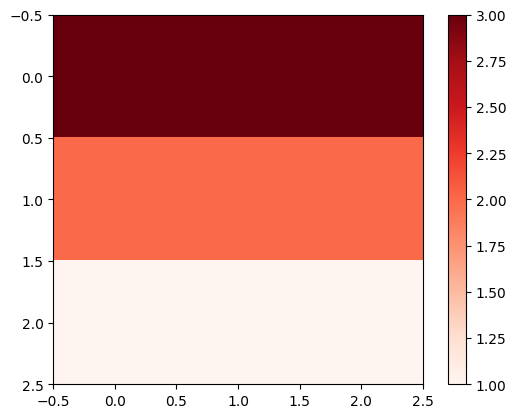

In [2]:
aw = models.Aw_cnn()
ah = models.Ah_cnn()
tensor = torch.tensor([[[3., 3.,3.], [2.,2.,2.], [1.,1.,1.]], [[3., 3.,3.], [2.,2.,2.], [1.,1.,1.]]])
# tensor = torch.tensor([[[9.,8.,7.], [6.,5.,4.], [3.,2.,1.]], [[9.,8.,7.], [6.,5.,4.], [3.,2.,1.]]])
plt.imshow(tensor[0], cmap='Reds')
plt.colorbar()

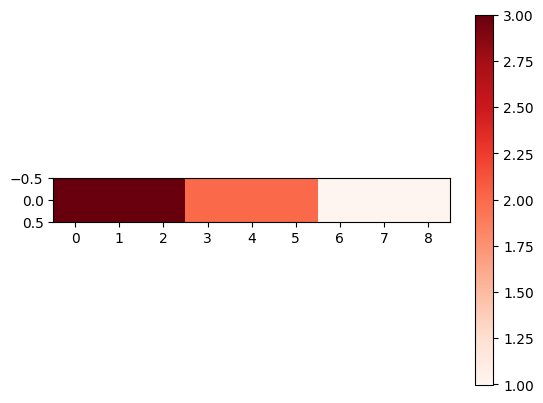

In [3]:
reshaped = tensor.reshape(tensor.shape[0], 1, tensor.shape[2] * tensor.shape[1])

plt.imshow(reshaped[0], cmap='Reds')
plt.colorbar()

In [4]:
reshaped.shape

torch.Size([2, 1, 9])

Aw in: torch.Size([2, 3, 3])
Aw reshaped: torch.Size([2, 1, 9])
Aw out: torch.Size([2, 3, 3])
Ah in: torch.Size([2, 3, 3])
Ah reshaped: torch.Size([6, 1, 3])
Ah out: torch.Size([2, 3, 3])


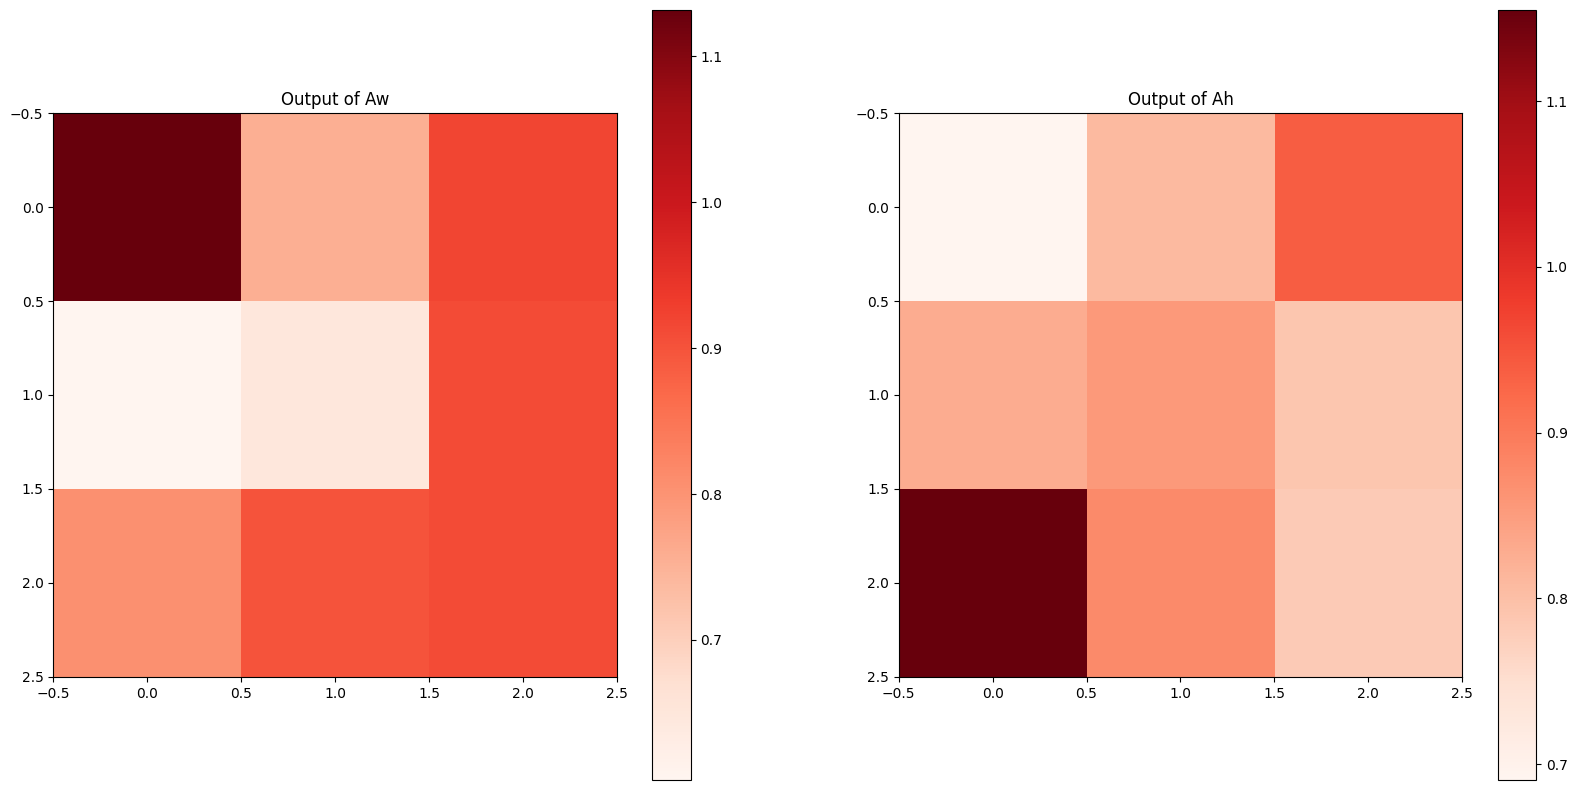

In [5]:
with torch.no_grad():
    y = aw(tensor)
    y2 = ah(tensor)

fig, axs = plt.subplots(1, 2, figsize= (20,10))
im1 = axs[0].imshow(y[0].detach(), cmap='Reds')
axs[0].set_title("Output of Aw")
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(y2[0].detach(), cmap='Reds')
axs[1].set_title("Output of Ah")
plt.colorbar(im2, ax=axs[1])